# Imports

In [369]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import inv

sns.set_style("whitegrid")

# Reading Data

In [370]:
dataPath = 'data/data/'

def load_data(path):
    data = {}
    data_rf = {}
    for files in os.listdir(path):
        if files.endswith('.csv') and 'spf' not in files:
            data[files] = pd.read_csv(path + files)
            data[files] = data[files].dropna()
            data[files]['Return'] = (data[files]['Close'] - data[files]['Open'])/data[files]['Open']
            data[files] = data[files]['Return'].values
            if 'rf_' in files:
                data_rf[files] = data[files]
                del data[files]
    return data, data_rf

In [371]:
data_risky, data_rf = load_data(dataPath)

# Covariance Matrix

In [372]:
covarianceMatrixStar = np.cov(np.array(list(data_risky.values())))

# Mean Returns

In [373]:
meanReturnsR = np.mean(np.array(list(data_risky.values())), axis=1)
meanReturnRf = np.mean(np.array(list(data_rf.values())), axis=1)[0]

# Efficient Frontier

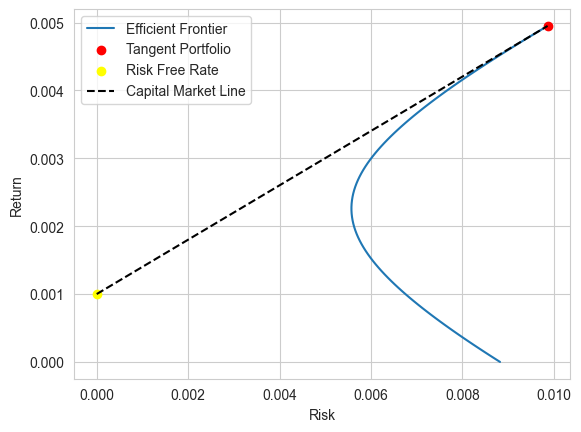

In [374]:
def efficient_frontier(avgReturn, risk, rf):
    def calc_best_weights(avgReturn, risk, tarReturn):
        n = len(avgReturn)
        O = np.ones(n) 
        C = np.array(risk)
        U = tarReturn
        M = np.array(avgReturn)
        a = O @ np.linalg.inv(C) @ O.T
        b = O @ np.linalg.inv(C) @ M.T
        c = M @ np.linalg.inv(C) @ O.T
        d = M @ np.linalg.inv(C) @ M.T
        l1 = (d - b * U) / (a * d - b * c)
        l2 = (a * U - c) / (a * d - b * c)
        w = np.linalg.inv(C) @ (l1 * O.T + l2 * M.T)
        return w

    def calc_risk(w, risk):
        return w @ risk @ w.T

    def calc_tangent_weights(risk, avgReturn, rf):
        n = len(avgReturn)
        O = np.ones(n) 
        C = np.array(risk)
        M = np.array(avgReturn)
        a = inv(C)@(M.T - rf * O.T)
        b = O@inv(C)@(M.T - rf * O.T)
        w = a/b
        return w

    w_tangent = calc_tangent_weights(risk, avgReturn, rf)
    risk_tangent = calc_risk(w_tangent, risk)
    avgReturn_tangent = w_tangent @ avgReturn
    sigma_der = risk_tangent**0.5

    targetReturns = np.linspace(0, max(avgReturn), 100)
    best_weights = [calc_best_weights(avgReturn, risk, i) for i in targetReturns]
    risk_best_weights = [calc_risk(i, risk) for i in best_weights]
    sigma_best_weights = [i**0.5 for i in risk_best_weights]

    plt.plot(sigma_best_weights, targetReturns, label='Efficient Frontier')
    plt.scatter(sigma_der, avgReturn_tangent, label='Tangent Portfolio', color='red')
    plt.scatter(0, rf, label='Risk Free Rate', color='yellow')
    plt.plot([0, sigma_der], [rf, avgReturn_tangent], color='black', linestyle='dashed', label='Capital Market Line')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return sigma_der, avgReturn_tangent, w_tangent

sigma_der, avgReturn_tangent, w_tangent_point = efficient_frontier(meanReturnsR, covarianceMatrixStar, meanReturnRf)


# Defining Different Portfolios

In [375]:
ratio1 = 0.5
ratio2 = 0.2

w1 = w_tangent_point * ratio1
w2 = w_tangent_point * ratio2

return1 = w1 @ meanReturnsR + (1 - ratio1) * meanReturnRf
return2 = w2 @ meanReturnsR + (1 - ratio2) * meanReturnRf

risk1 = w1 @ covarianceMatrixStar @ w1.T
risk2 = w2 @ covarianceMatrixStar @ w2.T

sigma1 = risk1**0.5
sigma2 = risk2**0.5

# Market Returns

In [376]:
market = pd.read_csv('data/data/spf.csv')
market['Return'] = (market['Close/Last'] - market['Open'])/market['Open']

In [377]:
market_myu = np.mean(market['Return'])

# Betas

In [378]:
betas = {}

for i in data_risky.keys():
    betas[i] = np.cov(data_risky[i], market['Return'])[0][1] / np.var(market['Return'])

# Expected Returns

In [379]:
expected_returns = {}
for i in data_risky.keys():
    expected_returns[i] = meanReturnRf + betas[i] * (market_myu - meanReturnRf)
for i in expected_returns.keys():
    print(f'{i[:-4]} - {expected_returns[i]}')

AAPL - 0.0011068225632760958
ADANIPOWER.NS - 0.0011059685269664222
AMD - 0.0007153381239336159
F - 0.0012290730932520491
INTC - 0.000983452310840873
META - 0.001007297847082427
MSFT - 0.0010947671735435927
QCOM - 0.001108500846471251
RELIANCE.NS - 0.0012524684013164298
TSLA - 0.00189758573975031


# Security Market Line

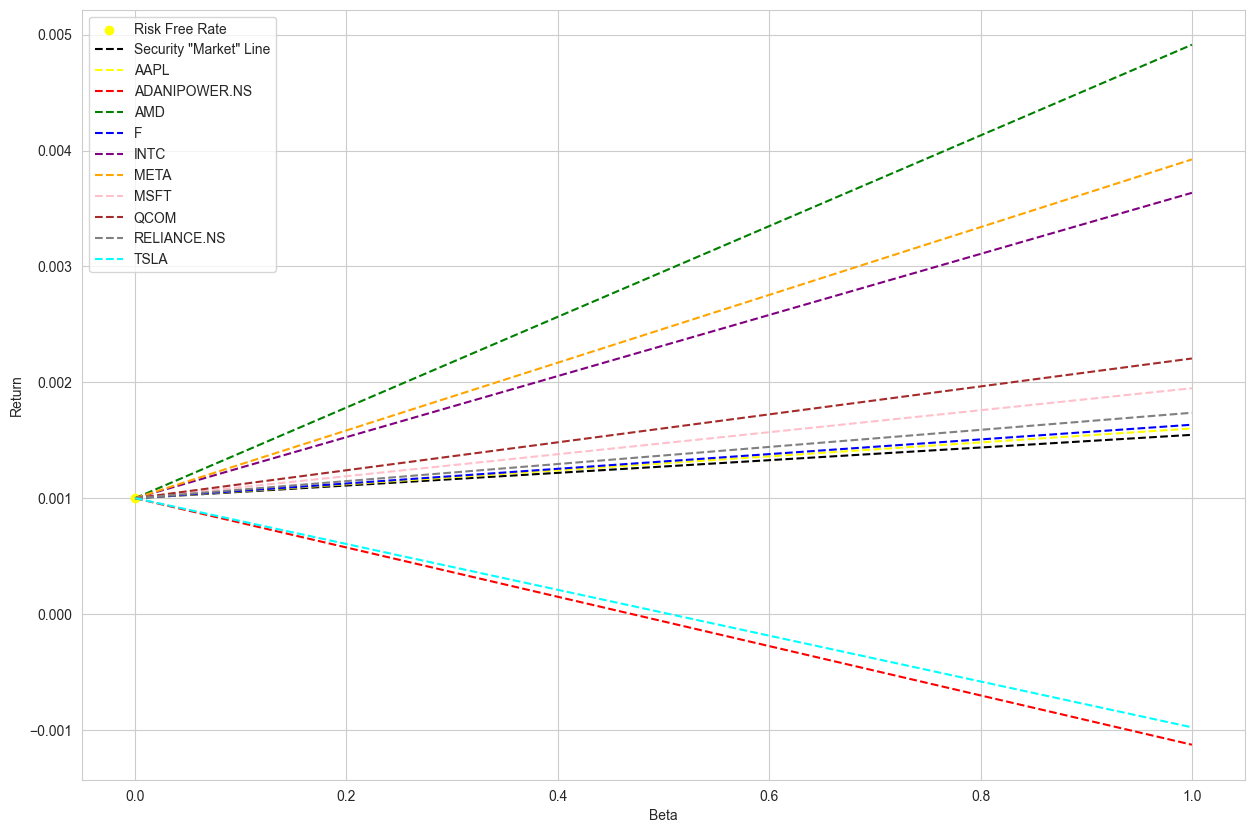

In [387]:
def security_market_lines(market_myu, meanReturnsR, betas, rf_myu):
    fig = plt.figure(figsize=(15, 10))
    plt.scatter(0, rf_myu, label='Risk Free Rate', color='yellow')
    plt.plot([0, 1], [rf_myu, market_myu], color='black', linestyle='dashed', label='Security "Market" Line')
    colors = ['yellow', 'red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'grey', 'cyan']
    for ix,i in enumerate(betas.keys()):
        plt.plot([0, 1], [rf_myu, meanReturnsR[ix]], color=colors[ix], linestyle='dashed', label=f'{i[:-4]}')
    plt.xlabel('Beta')
    plt.ylabel('Return')
    plt.legend()
    plt.legend(loc='upper left')
    plt.show()

security_market_lines(market_myu, meanReturnsR, betas, meanReturnRf)

# Sharpe and Treynor Ratios

In [381]:
def sharpe_ratios(myu_star, std_star, rf, expected_returns):
    sharpe_ratios = {}
    sharpe_ratios['portfolio'] = (myu_star - rf) / std_star

    for i in expected_returns.keys():
        sharpe_ratios[i] = (expected_returns[i] - rf) / np.std(data_risky[i])

    return sharpe_ratios

def treynor_ratios(myu_star, betas, rf, expected_returns, w_tangent_point):
    treynor_ratios = {}
    beta_portfolio = w_tangent_point @ np.array(list(betas.values()))
    treynor_ratios['portfolio'] = (myu_star - rf) / beta_portfolio

    for i in expected_returns.keys():
        treynor_ratios[i] = (expected_returns[i] - rf) / betas[i]

    return treynor_ratios

In [382]:
sharpe_ratios_ = sharpe_ratios(avgReturn_tangent, sigma_der, meanReturnRf, expected_returns)
treynor_ratios_ = treynor_ratios(avgReturn_tangent, betas, meanReturnRf, expected_returns, w_tangent_point)

for i in sharpe_ratios_.keys():
    if i != 'portfolio':
        print(f'{i[:-4]} - Sharpe Ratio: {sharpe_ratios_[i]}')
    else:
        print(f'Portfolio Marko- Sharpe Ratio: {sharpe_ratios_[i]}')

print("-------------------")

for i in treynor_ratios_.keys():
    if i != 'portfolio':
        print(f'{i[:-4]} - Treynor Ratio: {treynor_ratios_[i]}')
    else:
        print(f'Portfolio Marko- Treynor Ratio: {treynor_ratios_[i]}')

Portfolio Marko- Sharpe Ratio: 0.400621819582343
AAPL - Sharpe Ratio: 0.012981986434434455
ADANIPOWER.NS - Sharpe Ratio: 0.003216858329258295
AMD - Sharpe Ratio: -0.013536541168983108
F - Sharpe Ratio: 0.013072035516164435
INTC - Sharpe Ratio: -0.0010017027745127353
META - Sharpe Ratio: 0.000565040438834808
MSFT - Sharpe Ratio: 0.010256619319375085
QCOM - Sharpe Ratio: 0.010639963396855459
RELIANCE.NS - Sharpe Ratio: 0.01970838422150309
TSLA - Sharpe Ratio: 0.04457798357252183
-------------------
Portfolio Marko- Treynor Ratio: -0.0077741919986532735
AAPL - Treynor Ratio: 0.0005466758920680525
ADANIPOWER.NS - Treynor Ratio: 0.0005466758920680522
AMD - Treynor Ratio: 0.0005466758920680526
F - Treynor Ratio: 0.0005466758920680527
INTC - Treynor Ratio: 0.0005466758920680527
META - Treynor Ratio: 0.0005466758920680596
MSFT - Treynor Ratio: 0.0005466758920680526
QCOM - Treynor Ratio: 0.0005466758920680532
RELIANCE.NS - Treynor Ratio: 0.0005466758920680529
TSLA - Treynor Ratio: 0.00054667589

In [383]:
sharpe_ratios_ = sharpe_ratios(return1, sigma1, meanReturnRf, expected_returns)
treynor_ratios_ = treynor_ratios(return1, betas, meanReturnRf, expected_returns, w1)

In [384]:
for i in sharpe_ratios_.keys():
    if i != 'portfolio':
        print(f'{i[:-4]} - Sharpe Ratio: {sharpe_ratios_[i]}')
    else:
        print(f'Portfolio 1 - Sharpe Ratio: {sharpe_ratios_[i]}')

print("-------------------")

for i in treynor_ratios_.keys():
    if i != 'portfolio':
        print(f'{i[:-4]} - Treynor Ratio: {treynor_ratios_[i]}')
    else:
        print(f'Portfolio 1 - Treynor Ratio: {treynor_ratios_[i]}')

Portfolio 1 - Sharpe Ratio: 0.400621819582343
AAPL - Sharpe Ratio: 0.012981986434434455
ADANIPOWER.NS - Sharpe Ratio: 0.003216858329258295
AMD - Sharpe Ratio: -0.013536541168983108
F - Sharpe Ratio: 0.013072035516164435
INTC - Sharpe Ratio: -0.0010017027745127353
META - Sharpe Ratio: 0.000565040438834808
MSFT - Sharpe Ratio: 0.010256619319375085
QCOM - Sharpe Ratio: 0.010639963396855459
RELIANCE.NS - Sharpe Ratio: 0.01970838422150309
TSLA - Sharpe Ratio: 0.04457798357252183
-------------------
Portfolio 1 - Treynor Ratio: -0.0077741919986532735
AAPL - Treynor Ratio: 0.0005466758920680525
ADANIPOWER.NS - Treynor Ratio: 0.0005466758920680522
AMD - Treynor Ratio: 0.0005466758920680526
F - Treynor Ratio: 0.0005466758920680527
INTC - Treynor Ratio: 0.0005466758920680527
META - Treynor Ratio: 0.0005466758920680596
MSFT - Treynor Ratio: 0.0005466758920680526
QCOM - Treynor Ratio: 0.0005466758920680532
RELIANCE.NS - Treynor Ratio: 0.0005466758920680529
TSLA - Treynor Ratio: 0.00054667589206805

In [385]:
sharpe_ratios_ = sharpe_ratios(return2, sigma2, meanReturnRf, expected_returns)
treynor_ratios_ = treynor_ratios(return2, betas, meanReturnRf, expected_returns, w2)

for i in sharpe_ratios_.keys():
    if i != 'portfolio':
        print(f'{i[:-4]} - Sharpe Ratio: {sharpe_ratios_[i]}')
    else:
        print(f'Portfolio 2 - Sharpe Ratio: {sharpe_ratios_[i]}')

print("-------------------")

for i in treynor_ratios_.keys():
    if i != 'portfolio':
        print(f'{i[:-4]} - Treynor Ratio: {treynor_ratios_[i]}')
    else:
        print(f'Portfolio 2 - Treynor Ratio: {treynor_ratios_[i]}')

Portfolio 2 - Sharpe Ratio: 0.400621819582343
AAPL - Sharpe Ratio: 0.012981986434434455
ADANIPOWER.NS - Sharpe Ratio: 0.003216858329258295
AMD - Sharpe Ratio: -0.013536541168983108
F - Sharpe Ratio: 0.013072035516164435
INTC - Sharpe Ratio: -0.0010017027745127353
META - Sharpe Ratio: 0.000565040438834808
MSFT - Sharpe Ratio: 0.010256619319375085
QCOM - Sharpe Ratio: 0.010639963396855459
RELIANCE.NS - Sharpe Ratio: 0.01970838422150309
TSLA - Sharpe Ratio: 0.04457798357252183
-------------------
Portfolio 2 - Treynor Ratio: -0.007774191998653274
AAPL - Treynor Ratio: 0.0005466758920680525
ADANIPOWER.NS - Treynor Ratio: 0.0005466758920680522
AMD - Treynor Ratio: 0.0005466758920680526
F - Treynor Ratio: 0.0005466758920680527
INTC - Treynor Ratio: 0.0005466758920680527
META - Treynor Ratio: 0.0005466758920680596
MSFT - Treynor Ratio: 0.0005466758920680526
QCOM - Treynor Ratio: 0.0005466758920680532
RELIANCE.NS - Treynor Ratio: 0.0005466758920680529
TSLA - Treynor Ratio: 0.000546675892068052